In [1]:
# since we work in a couple, we should check python version in advance and set it to 3.6.5
from platform import python_version
print(python_version())

3.6.5


# Introduction

X-ray imaging is one of the most widely used diagnostic examinations for the diagnosis and research of numerous types of illnesses, making it a high-potential source of data for the development of computer-aided detection and diagnosis tools.

The full dataset at hand is comprised of 112,120 chest X-ray images (in size 1024*1024) of 30,805 unique patients, which were classified into 14 different types of lung diseases (including images which demonstrate multiple diseases), and images of healthy individuals.

Several groups have addressed  this multi-label dataset in attempt to classify the images according to different research goals - some classified all 14 classes (diseases) [1],[2] or part of the diseases [3], some identified patients with one specific disease vs healthy patients, and some looked for the correlation between two (or more) diseases.

In this work we decided to simplify the problem and focus on classifying the images to patients who demonstrate Effusion (a fluid in the space around the lung), other diseases or healthy patients (3 classes). The main reason for this decision is the high frequency of the disease in the available dataset. Moreover, according to radiologist [4], this phenomena labeling seem to be more accurate than other diseases.

The image below represents eight common thoracic diseases [3].

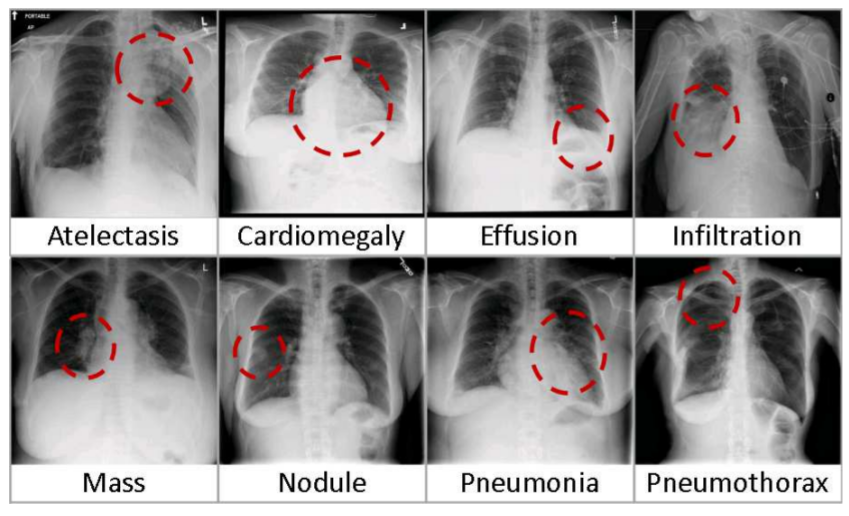

[1] Pranav Rajpurkar et al., CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning, (2017), URL https://arxiv.org/abs/1705.02315

[2] Pranav Rajpurkar et al., Deep learning for chest radiograph diagnosis: A retrospective comparison of the CheXNeXt algorithm to practicing radiologists, (2018), URL https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686

[3] Xiaosong Wang et al., ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, (2017), URL http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

[4] Luke Oakden-Rayner, Exploring the ChestXray14 dataset: problems, (2017), URL https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/


# Import packages

In [2]:
# Load and group images
import os
from glob import glob
# Work with dataframes
import pandas as pd
# Image representation
import cv2
# Plot packages
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="darkgrid") # adds grid to seaborn's plots
# Random sampling
import random
import numpy as np


# Load input files

### Load images

In [3]:
# After extracting all images to a folder named 'images'
path = os.path.abspath(os.path.join('..', 'project - NIH random sampled'))
source_images = os.path.join(path, "images")
images = glob(os.path.join(source_images, "*.png"))

images[0:5]

['C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000013_005.png',
 'C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000013_026.png',
 'C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000017_001.png',
 'C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000030_001.png',
 'C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000032_001.png']

In [4]:
### ~~~ An attempt to open from zip file directly, without extracting all files ~~~~ ###

#from zipfile import ZipFile

#archive = ZipFile('sample.zip', 'r')
#images = archive.namelist()

#images[0:10]

In [5]:
### ~~~ Use to check the running time of a procedure ~~~ ###
#import time

#start_time = time.time()

#print("--- %s seconds ---" % (time.time() - start_time))

### Load csv file

In [6]:
all_xray_df = pd.read_csv('Data_Entry_2017.csv')

all_xray_df.sample(5)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
83277,00020450_010.png,Emphysema,10,20450,59,M,AP,3056,2544,0.139,0.139,NaN
103341,00027564_001.png,Nodule,1,27564,50,M,PA,2992,2991,0.143,0.143,NaN
77968,00019145_006.png,Infiltration,6,19145,46,F,PA,2502,2991,0.143,0.143,NaN
80646,00019805_005.png,Consolidation|Infiltration|Mass|Nodule,5,19805,29,M,AP,3056,2544,0.139,0.139,NaN
16582,00004435_023.png,Effusion,23,4435,28,F,AP,2500,2048,0.171,0.171,NaN


### Represent 3 random images to validate the loading process

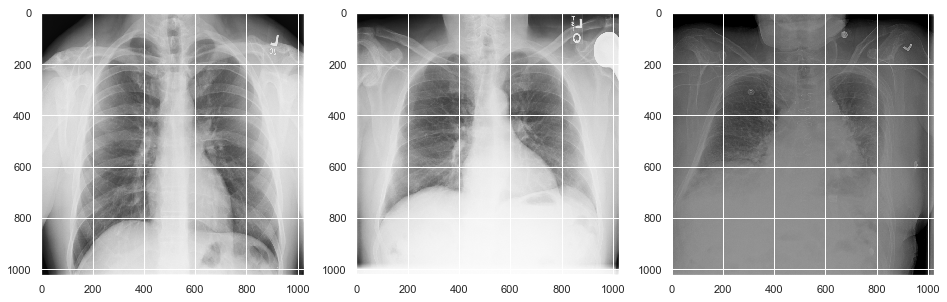

In [7]:
r = random.sample(images, 3)

fig = plt.figure(figsize=(16,16))

plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]))
plt.show()

# Explanatory Data Analysis (EDA)

## Preprocessing - organize the data

### Keep relevant columns

The original data included 4 additional columns with parameters which describe the original size of the images (weight, height, etc.).
We currently want to remove these known parameters since the images have been resized to 1024*1024 and we may be interested mainly in the rest of the variables.

In [8]:
all_xray_df = all_xray_df[['Image Index','Finding Labels','Follow-up #',
                           'Patient ID','Patient Age','Patient Gender','View Position']]

In [9]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


### Describe all parameters to understand data and search for missing values

In [10]:
all_xray_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120
unique,112120,836,NaN,NaN,NaN,2,2
top,00018536_002.png,No Finding,NaN,NaN,NaN,M,PA
freq,1,60361,NaN,NaN,NaN,63340,67310
mean,NaN,NaN,8.573751,14346.381743,46.901463,NaN,NaN
std,NaN,NaN,15.406320,8403.876972,16.839923,NaN,NaN
min,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN
25%,NaN,NaN,0.000000,7310.750000,35.000000,NaN,NaN
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN


As represented in the table above, there are no missing values for all variables (both categorical and numerical).

According to 'Patient ID', the database includes 112,120 x-ray images of 30,805 unique patients.

It can be observed that 60,361 out of 112,120 images represent healthy subjects ('No Finding'). 
Moreover, 56% of the subjects are males and 60% of the images' view position is posterioranterior (PA, when patient's back faces the machine).

It can also be observed that there are outliers of patient age, since 414 years is the maximal value, and that the follow-up median # is 3, while the mean is 8.5, meaning the distribution is not normal.

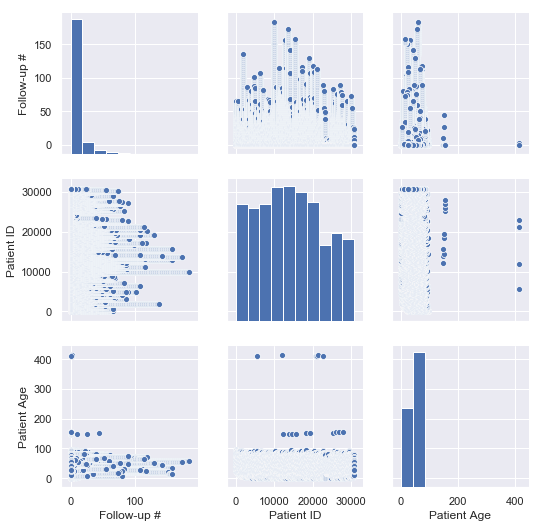

In [11]:
# Represent relations between the numerical variables by representing distributions
sns.pairplot(all_xray_df)
plt.show()

According to the pairplot, there are 5 images with patient age over 400, and another 10 images having age above 100.
Moreover, there is no significant correlation between the follow up # and the patient age.

Yet, since we currently are interested in classifying only the images data, we decided not to remove the outliers of the 'age' variables, since we do not mind that they were mistakenly documented.

## Understand the data in matters of the amount of each pathology

In [12]:
# List of pathologies

list_pathology = ['Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
                  'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
                  'Cardiomegaly','Nodule','Mass','Hernia','No Finding']

In [13]:
# Create a column 0f 0/1 for each desease

for pathology in list_pathology :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [14]:
# create a new df that includes the image index and the count (0/1) of each pathology for each image

separate_disease = pd.melt(all_xray_df, id_vars=['Image Index'], value_vars = list_pathology,
                           var_name = 'Pathology', value_name = 'Count' )
# keep rows that represent a disease
separate_disease = separate_disease.loc[separate_disease.Count>0]

# print for convience
print( separate_disease.head() )
print( separate_disease.shape )

          Image Index    Pathology  Count
34   00000011_006.png  Atelectasis      1
68   00000013_030.png  Atelectasis      1
73   00000013_035.png  Atelectasis      1
92   00000019_000.png  Atelectasis      1
111  00000030_000.png  Atelectasis      1
(141537, 3)


In [15]:
# save the amount of each pathology in a descending order
disease_freq = separate_disease.groupby('Pathology')['Count'].sum()
disease_freq = disease_freq.sort_values(axis=0, ascending=False)

# remove 'No finding' (60,391 cases), since we are mainly interested in the pathologies
disease_freq = disease_freq.drop( ['No Finding'] )

# print for convience
disease_freq

Pathology
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: Count, dtype: int64

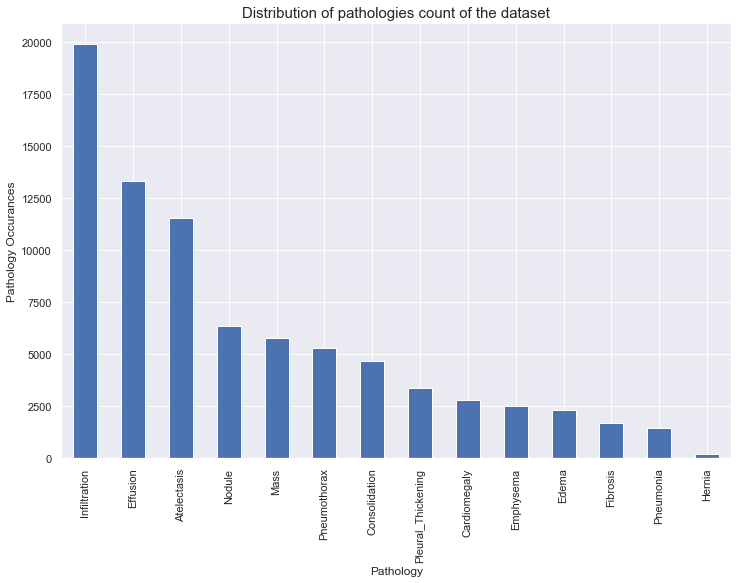

In [16]:
# plot
plt.figure(figsize=(12,8))

disease_freq.plot(kind='bar')
plt.ylabel('Pathology Occurances')
plt.title('Distribution of pathologies count of the dataset',fontsize=15)
plt.show()


According to the above we can see that 'Effusion' is one of the most common observations in this dataset, therefore we have decided to classify the data to the 3 following catagories: Effusion (1), Other disease (2), Healthy (3)

### Prepare a labels (Y) column with 3 classes - Effusion (1), Other disease (2), Healthy (3)

Creation of a new parameter called '3class_label':

In [17]:
# Create new column ('3class_label')

def new_label(row):
    if row['No Finding'] == 1:
        return 3
    elif row['Effusion'] == 1:
        return 1
    return 2
  
all_xray_df['3class_label'] = all_xray_df.apply( lambda row: new_label(row),axis=1 )

In [18]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Consolidation,Infiltration,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,3class_label
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,2
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,00000002_000.png,No Finding,0,2,81,M,PA,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,00000003_000.png,Hernia,0,3,81,F,PA,0,0,0,...,0,0,0,0,0,0,0,1,0,2


## Parameters distribution between the 3 new catagories 

### Images Distribution

In [19]:
class_size = all_xray_df.groupby('3class_label').size().reset_index(name='size')
class_size

,3class_label,size
0,1,13317
1,2,38442
2,3,60361


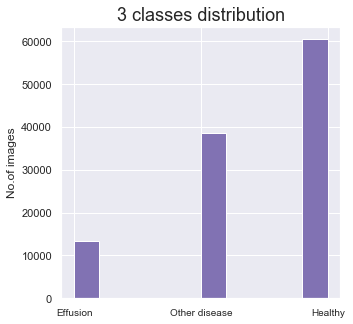

In [20]:
# Plot amount of 3 labels
all_xray_df[['3class_label']].hist(figsize = (5, 5), color='C4')
plt.xticks([1,2,3],['Effusion','Other disease','Healthy'], fontsize=10)
plt.title('3 classes distribution', fontsize=18)
plt.ylabel("No.of images")
plt.show()

After the re-classicifation we now have: 
13,317 images of 'Effusion', 38,442 Images of 'Other diseases' and 60,361 'Healthy' images.

### Distribution of View Position (PA/AP) / Gender

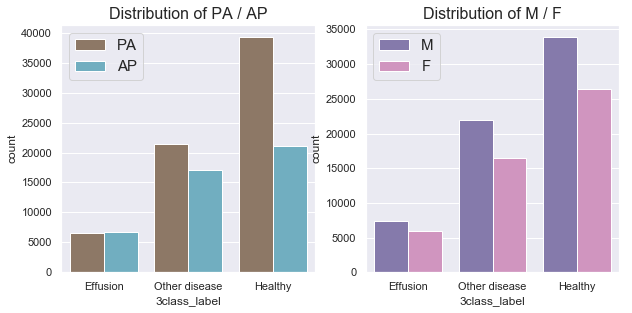

In [21]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1)
g=sns.countplot(x='3class_label', hue='View Position', data=all_xray_df, ax=ax, palette=["C5", "C9"]) # palette - colors
plt.xticks([0,1,2],['Effusion','Other disease','Healthy'])
ax.legend(fontsize=15)
ax.set_title('Distribution of PA / AP',fontsize=16)

ax1 = fig.add_subplot(2,2,2)
g=sns.countplot(x='3class_label', hue='Patient Gender', data=all_xray_df, ax=ax1, palette=["C4", "C6"])
plt.xticks([0,1,2],['Effusion','Other disease','Healthy'])
ax1.legend(fontsize=15)
ax1.set_title('Distribution of M / F',fontsize=16)
plt.show()


In [22]:
'''
plt.figure(figsize=(6,6))

all_xray_df['Patient Gender'].replace({'F':0,'M':1},inplace=True)

g=sns.countplot(x='Patient Gender', hue='3class_label', data=all_xray_df, palette=["C4", "C6","C7"])
plt.xticks([0,1],['M','F'])
#plt.legend(fontsize=15)
plt.title('Distribution of M / F',fontsize=16)
plt.show()
'''

'\nplt.figure(figsize=(6,6))\n\nall_xray_df[\'Patient Gender\'].replace({\'F\':0,\'M\':1},inplace=True)\n\ng=sns.countplot(x=\'Patient Gender\', hue=\'3class_label\', data=all_xray_df, palette=["C4", "C6","C7"])\nplt.xticks([0,1],[\'M\',\'F\'])\n#plt.legend(fontsize=15)\nplt.title(\'Distribution of M / F\',fontsize=16)\nplt.show()\n'

We can see there is no significant correlation between the X-ray position (PA/ AP) and the patient gender and the detection of 'Effusion'. 

### Age distribution of classes

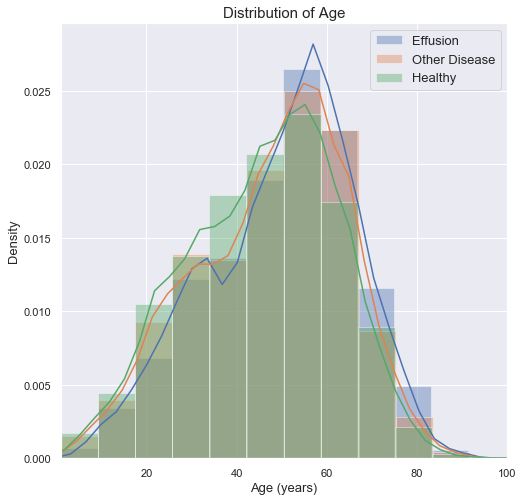

In [23]:
target_1 = all_xray_df.loc[all_xray_df['3class_label'] == 1]
target_2 = all_xray_df.loc[all_xray_df['3class_label'] == 2]
target_3 = all_xray_df.loc[all_xray_df['3class_label'] == 3]

plt.figure(figsize=(8,8))

f = sns.distplot(target_1[['Patient Age']], hist=True, bins=50, label='Effusion' )
sns.distplot(target_2[['Patient Age']], hist=True, bins=50, label='Other Disease')
sns.distplot(target_3[['Patient Age']], hist=True, bins=50, label='Healthy')
f.set_xlim(1,100)

plt.xlabel('Age (years)',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('Distribution of Age',fontsize=15)

plt.legend(fontsize=13)
plt.show()

### Follow-up # distribution

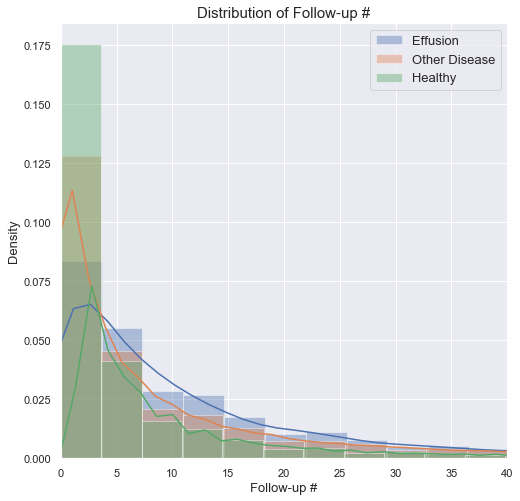

In [24]:
target_1 = all_xray_df.loc[all_xray_df['3class_label'] == 1]
target_2 = all_xray_df.loc[all_xray_df['3class_label'] == 2]
target_3 = all_xray_df.loc[all_xray_df['3class_label'] == 3]

plt.figure(figsize=(8,8))

f = sns.distplot(target_1[['Follow-up #']], hist=True, bins=50, label='Effusion' )
sns.distplot(target_2[['Follow-up #']], hist=True, bins=50, label='Other Disease')
sns.distplot(target_3[['Follow-up #']], hist=True, bins=50, label='Healthy')
f.set_xlim(0,40)

plt.xlabel('Follow-up #',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('Distribution of Follow-up #',fontsize=15)

plt.legend(fontsize=13)
plt.show()

## Images Analysis

### Represent random images with labels

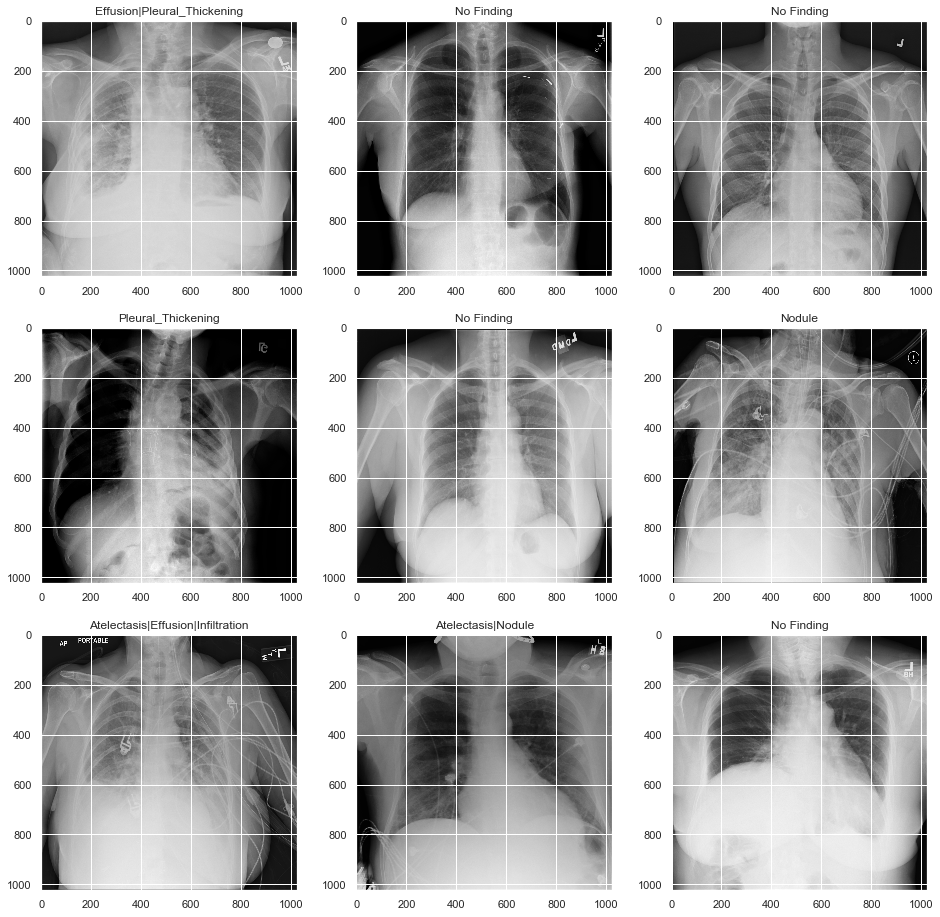

In [25]:
# Random sampling of 9 images
r = random.sample(images, 9)

fig = plt.figure(figsize=(16,16))

for i in range(9):
    img = cv2.imread(r[i])
    # image name
    file_name = os.path.basename(r[i])         
    # find image label 
    label_image = all_xray_df.loc[all_xray_df['Image Index'] == file_name, 'Finding Labels'].iloc[0]           

    ax = fig.add_subplot(3,3,i+1)                                                  
    ax.set_title( label_image )
    ax.imshow( img )

plt.show()


The representative images are examples of the reason that data augmentation may be usefull with such a data set.

### Creation of rezised images array

Images original size was 1024x1024, we are resizing the images to 512x512 in order to 'save' computing resources which will be required to run the models in later stages. We chose this specific size (and not smaller) to make sure no significant data is lost.

In [26]:
def proc_images():
    x = [] # images as arrays
    WIDTH = 512
    HEIGHT = 512
    for img in images:
        base = os.path.basename(img)
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
    return x

In [27]:
# For this stage we are running this command on a sample dataset which contains 5,606 random images:
X =proc_images()
df = pd.DataFrame()
df["images"]=X
print(len(df), df.images[0].shape)
print(type(X))

5606 (512, 512, 3)
<class 'list'>


### Pixels Histograms of representative images


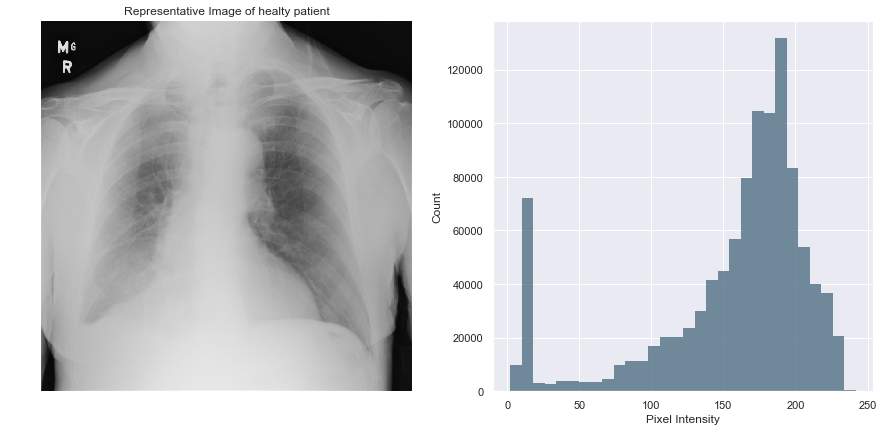

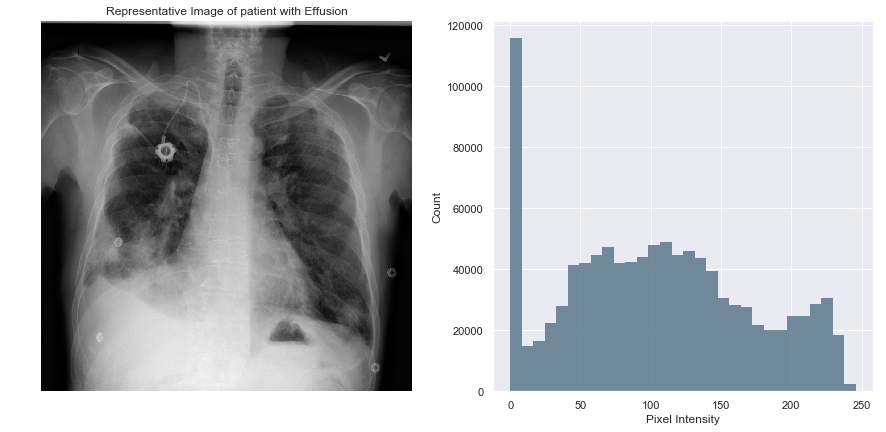

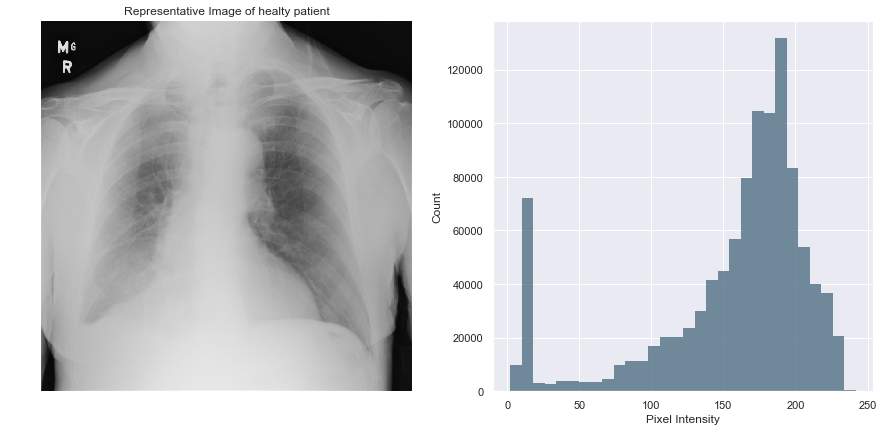

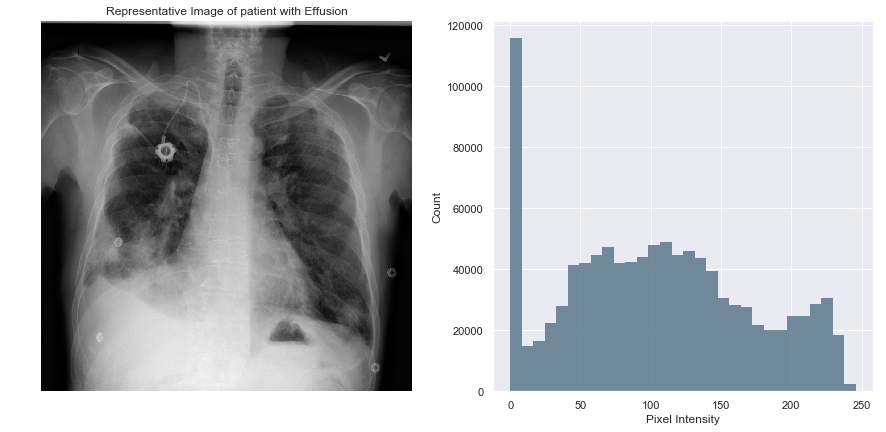

In [30]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title('Representative Image of healty patient')
    a= cv2.imread('C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000017_001.png')
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)
    
plotHistogram(X)

def plotHistogram(b):
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,3)
    plt.title('Representative Image of patient with Effusion')
    b = cv2.imread('C:\\Users\\Yair\\Data science - Technion\\project - NIH random sampled\\images\\00000061_002.png')    
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(b[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(b[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(b[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)


plotHistogram(X)
plt.show()

In [29]:
# Reduce the amount of images labeled as 'healthy'
# df_f = df[df.Cardiomegaly == 0].sample(3000)